# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

'Datacamp Task:' Your organization has asked you to explore and answer some questions from the data collected. 

### 1. Import needed libraries and dataset

#### 1.1 Load Key Libraries

In [202]:
# Import packages
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

#### 1.2 Load Dataset

In [203]:
# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

### 2. Data Exploration

In [204]:
# overview of dataset
drug_safety.head

<bound method NDFrame.head of        age   sex      trx  week  wbc  rbc adverse_effects  num_effects
0       62  male     Drug     0  7.3  5.1              No            0
1       62  male     Drug     1  NaN  NaN              No            0
2       62  male     Drug    12  5.6  5.0              No            0
3       62  male     Drug    16  NaN  NaN              No            0
4       62  male     Drug     2  6.6  5.1              No            0
...    ...   ...      ...   ...  ...  ...             ...          ...
16098   78  male  Placebo    16  NaN  NaN             Yes            1
16099   78  male  Placebo     2  7.5  4.9              No            0
16100   78  male  Placebo    20  NaN  NaN             Yes            1
16101   78  male  Placebo     4  6.4  4.8              No            0
16102   78  male  Placebo     8  7.8  4.8              No            0

[16103 rows x 8 columns]>

In [205]:
# basic exploration 
df_info = drug_safety.info()
print(f"Drug Safety Data Description:\n {df_info}\n\n")

non_na_values = drug_safety.count()
print(f"Non-Missing Values:\n{non_na_values}\n\n")

na_values = drug_safety.isnull().sum()
print(f"Missing Values:\n{na_values}\n\n")

summary_stats = drug_safety.describe()
print(f"Summary Statistics:\n{summary_stats}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB
Drug Safety Data Description:
 None


Non-Missing Values:
age                16103
sex                16103
trx                16103
week               16103
wbc                 9128
rbc                 9127
adverse_effects    16103
num_effects        16103
dtype: int64


Missing Values:
age                   0
sex                   0
trx                   0
week  

In [206]:
num_effects_check = drug_safety["num_effects"].nunique()
print(f"number of unique values: {num_effects_check}")

num_effects_check2 = drug_safety["num_effects"].unique()
print(f"list of unique values: {num_effects_check2}")


number of unique values: 4
list of unique values: [0 1 3 2]


In [207]:
# statistics for the treatment vs. control group
A1 = drug_safety.groupby("trx")["adverse_effects"].describe()
#A2 = drug_safety.groupby("trx")["num_effects"].describe(include="category")
A3 = drug_safety.groupby("trx")["age"].describe()
print(f"Treatment Groups vs. Adverse Effects:\n {A1}, \n\nTreatment Groups vs. Age:\n {A3}")

Treatment Groups vs. Adverse Effects:
          count unique top  freq
trx                            
Drug     10727      2  No  9703
Placebo   5376      2  No  4864, 

Treatment Groups vs. Age:
            count       mean       std   min   25%   50%   75%   max
trx                                                                
Drug     10727.0  64.190268  8.727154  39.0  58.0  65.0  71.0  82.0
Placebo   5376.0  63.972470  8.893038  39.0  58.0  65.0  71.0  84.0


>> Comments regarding the data:
- all participants are adults
- testing done over a period of 5 months (20 weeks / 4 weeks per month)
- adverse_effects is categorical: yes/no
- num_effects is categorical: 0,1,2,3

### 3. Statistical Testing

#### 3.1 Is there a significant difference in the proportion of adverse effects between the Drug and Placebo group?
- `Test`: two-sample proportions z-test
    - Null hypothesis (H0): there is no significant difference in the proportion of adverse effects between the two groups
    - Alternative hypothesis (HA): there is a significant difference in the proportion of adverse effects between the two groups (two-tailed test)
    - P-value threshold: 0.05

- `Output Variable`: two_sample_p_value

In [208]:
# observe adverse effect counts in the groups
trx_effects = drug_safety.groupby("trx")["adverse_effects"].value_counts()
print(trx_effects)

trx      adverse_effects
Drug     No                 9703
         Yes                1024
Placebo  No                 4864
         Yes                 512
Name: adverse_effects, dtype: int64


In [209]:
# number of positive reponse in both groups
drug_adverse_effect = trx_effects["Drug","Yes"]
print(f"number of participants in the drug group who experienced an adverse effect: {round(drug_adverse_effect,5)}")

placebo_adverse_effect = trx_effects["Placebo","Yes"]
print(f"number of participants in the placebo group who experienced an adverse effect: {round(placebo_adverse_effect, 5)}")

number of participants in the drug group who experienced an adverse effect: 1024
number of participants in the placebo group who experienced an adverse effect: 512


In [210]:
# number of observations
n_obs = drug_safety.groupby("trx")["adverse_effects"].count()
print(n_obs)

trx
Drug       10727
Placebo     5376
Name: adverse_effects, dtype: int64


In [211]:
# number of observations in each group
n_drug = n_obs["Drug"]
print(f"number of participants in the drug group: {n_drug}")

n_placebo = n_obs["Placebo"]
print(f"number of participants in the placebo group: {n_placebo}")

number of participants in the drug group: 10727
number of participants in the placebo group: 5376


In [212]:
# conversion to numpy array
n_adv_effect = np.array([drug_adverse_effect, placebo_adverse_effect])
print(n_adv_effect)

n_groups = np.array([n_drug, n_placebo])
print(n_groups)

[1024  512]
[10727  5376]


In [213]:
# calculate two-sample proportion test 
z_score, p_value = proportions_ztest(count=n_adv_effect, nobs=n_groups,
                                    alternative="two-sided")
two_sample_p_value = p_value
print(two_sample_p_value)

print('{0:0.3f}'.format(p_value))
print('{0:0.3f}'.format(z_score))

0.9639333330262475
0.964
0.045


>> Conclusion: since the calculated p value is greater than 0.05, there is no significant difference between the proportion of adverse effects observed between the two treatment group.

#### 3.2 Is the number of adverse effects independent of the treatment (Drug) vs. the control (Placebo) groups?
- `Test:` Chi-square test of independence
    - H0 = the number of adverse effects is independent of the treatment group
    - HA =  the number of adverse effects is dependent on the treatment group
- `Output Variable:` num_effects_p_value

<AxesSubplot: xlabel='trx'>

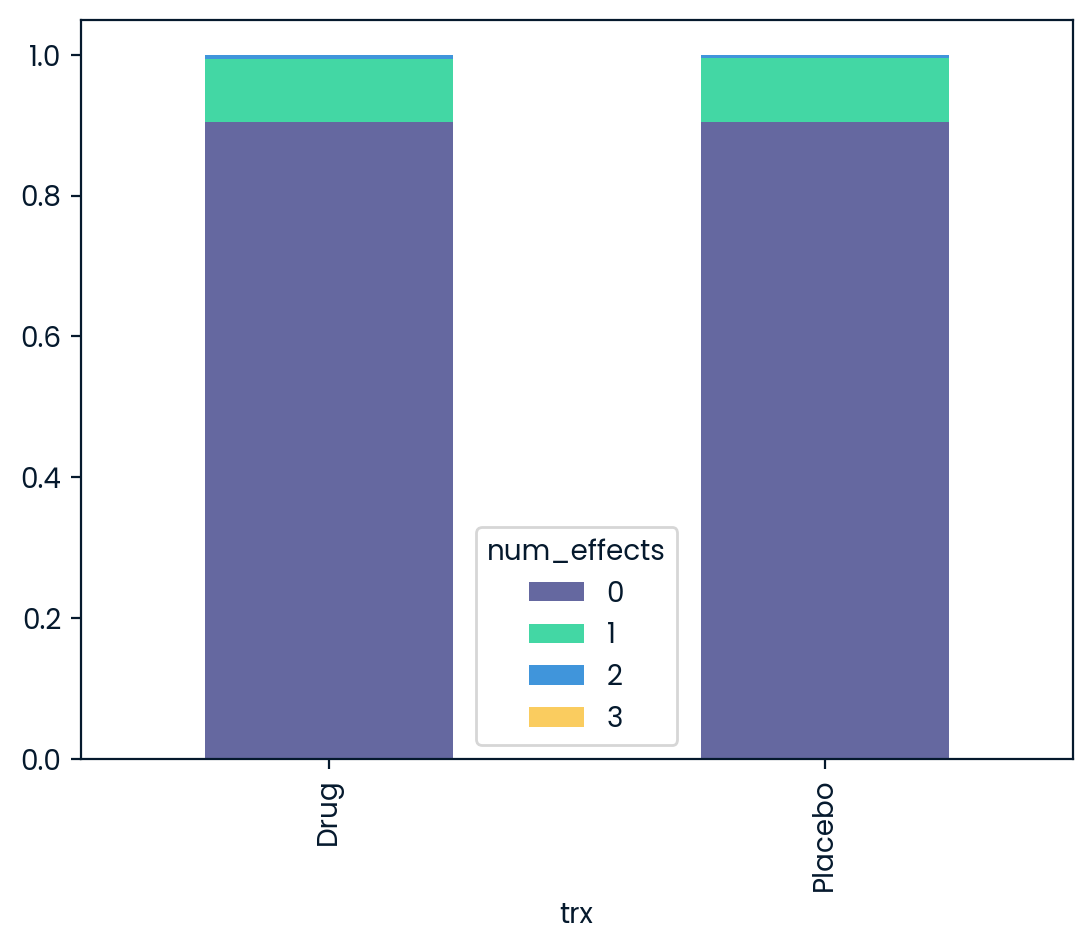

In [214]:
# visualize proportions
# convert from long data to wide data using .unstack()
trx_num_effects = drug_safety.groupby("trx")["num_effects"].value_counts(normalize=True).unstack()
trx_num_effects.plot(kind="bar", stacked="True")

In [215]:
# check number of effects count in each treatment group
trx_num_effects2 = drug_safety.groupby("trx")["num_effects"].value_counts(normalize=True)
print(trx_num_effects2)

trx      num_effects
Drug     0              0.904540
         1              0.089121
         2              0.005873
         3              0.000466
Placebo  0              0.904762
         1              0.090402
         2              0.004650
         3              0.000186
Name: num_effects, dtype: float64


In [216]:
expected, observed, stats = pingouin.chi2_independence(data=drug_safety, x="num_effects", y="trx")
print(stats)

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189


In [217]:
# save p-value for chi square test of independence
num_effects_p_value = stats.iloc[0, 4].round(3)
print(f"P-value from 'Chi Square Test of Independence' for numbers of adverse effects versus treatment/control group: {num_effects_p_value}")

P-value from 'Chi Square Test of Independence' for numbers of adverse effects versus treatment/control group: 0.615


>> Conclusion: the pvalue for the chi-square test of independence is also greater than 0.05. This indicates that the treatment group is independent of the number of adverse effects experienced by the participants.

##### Checking Normality 

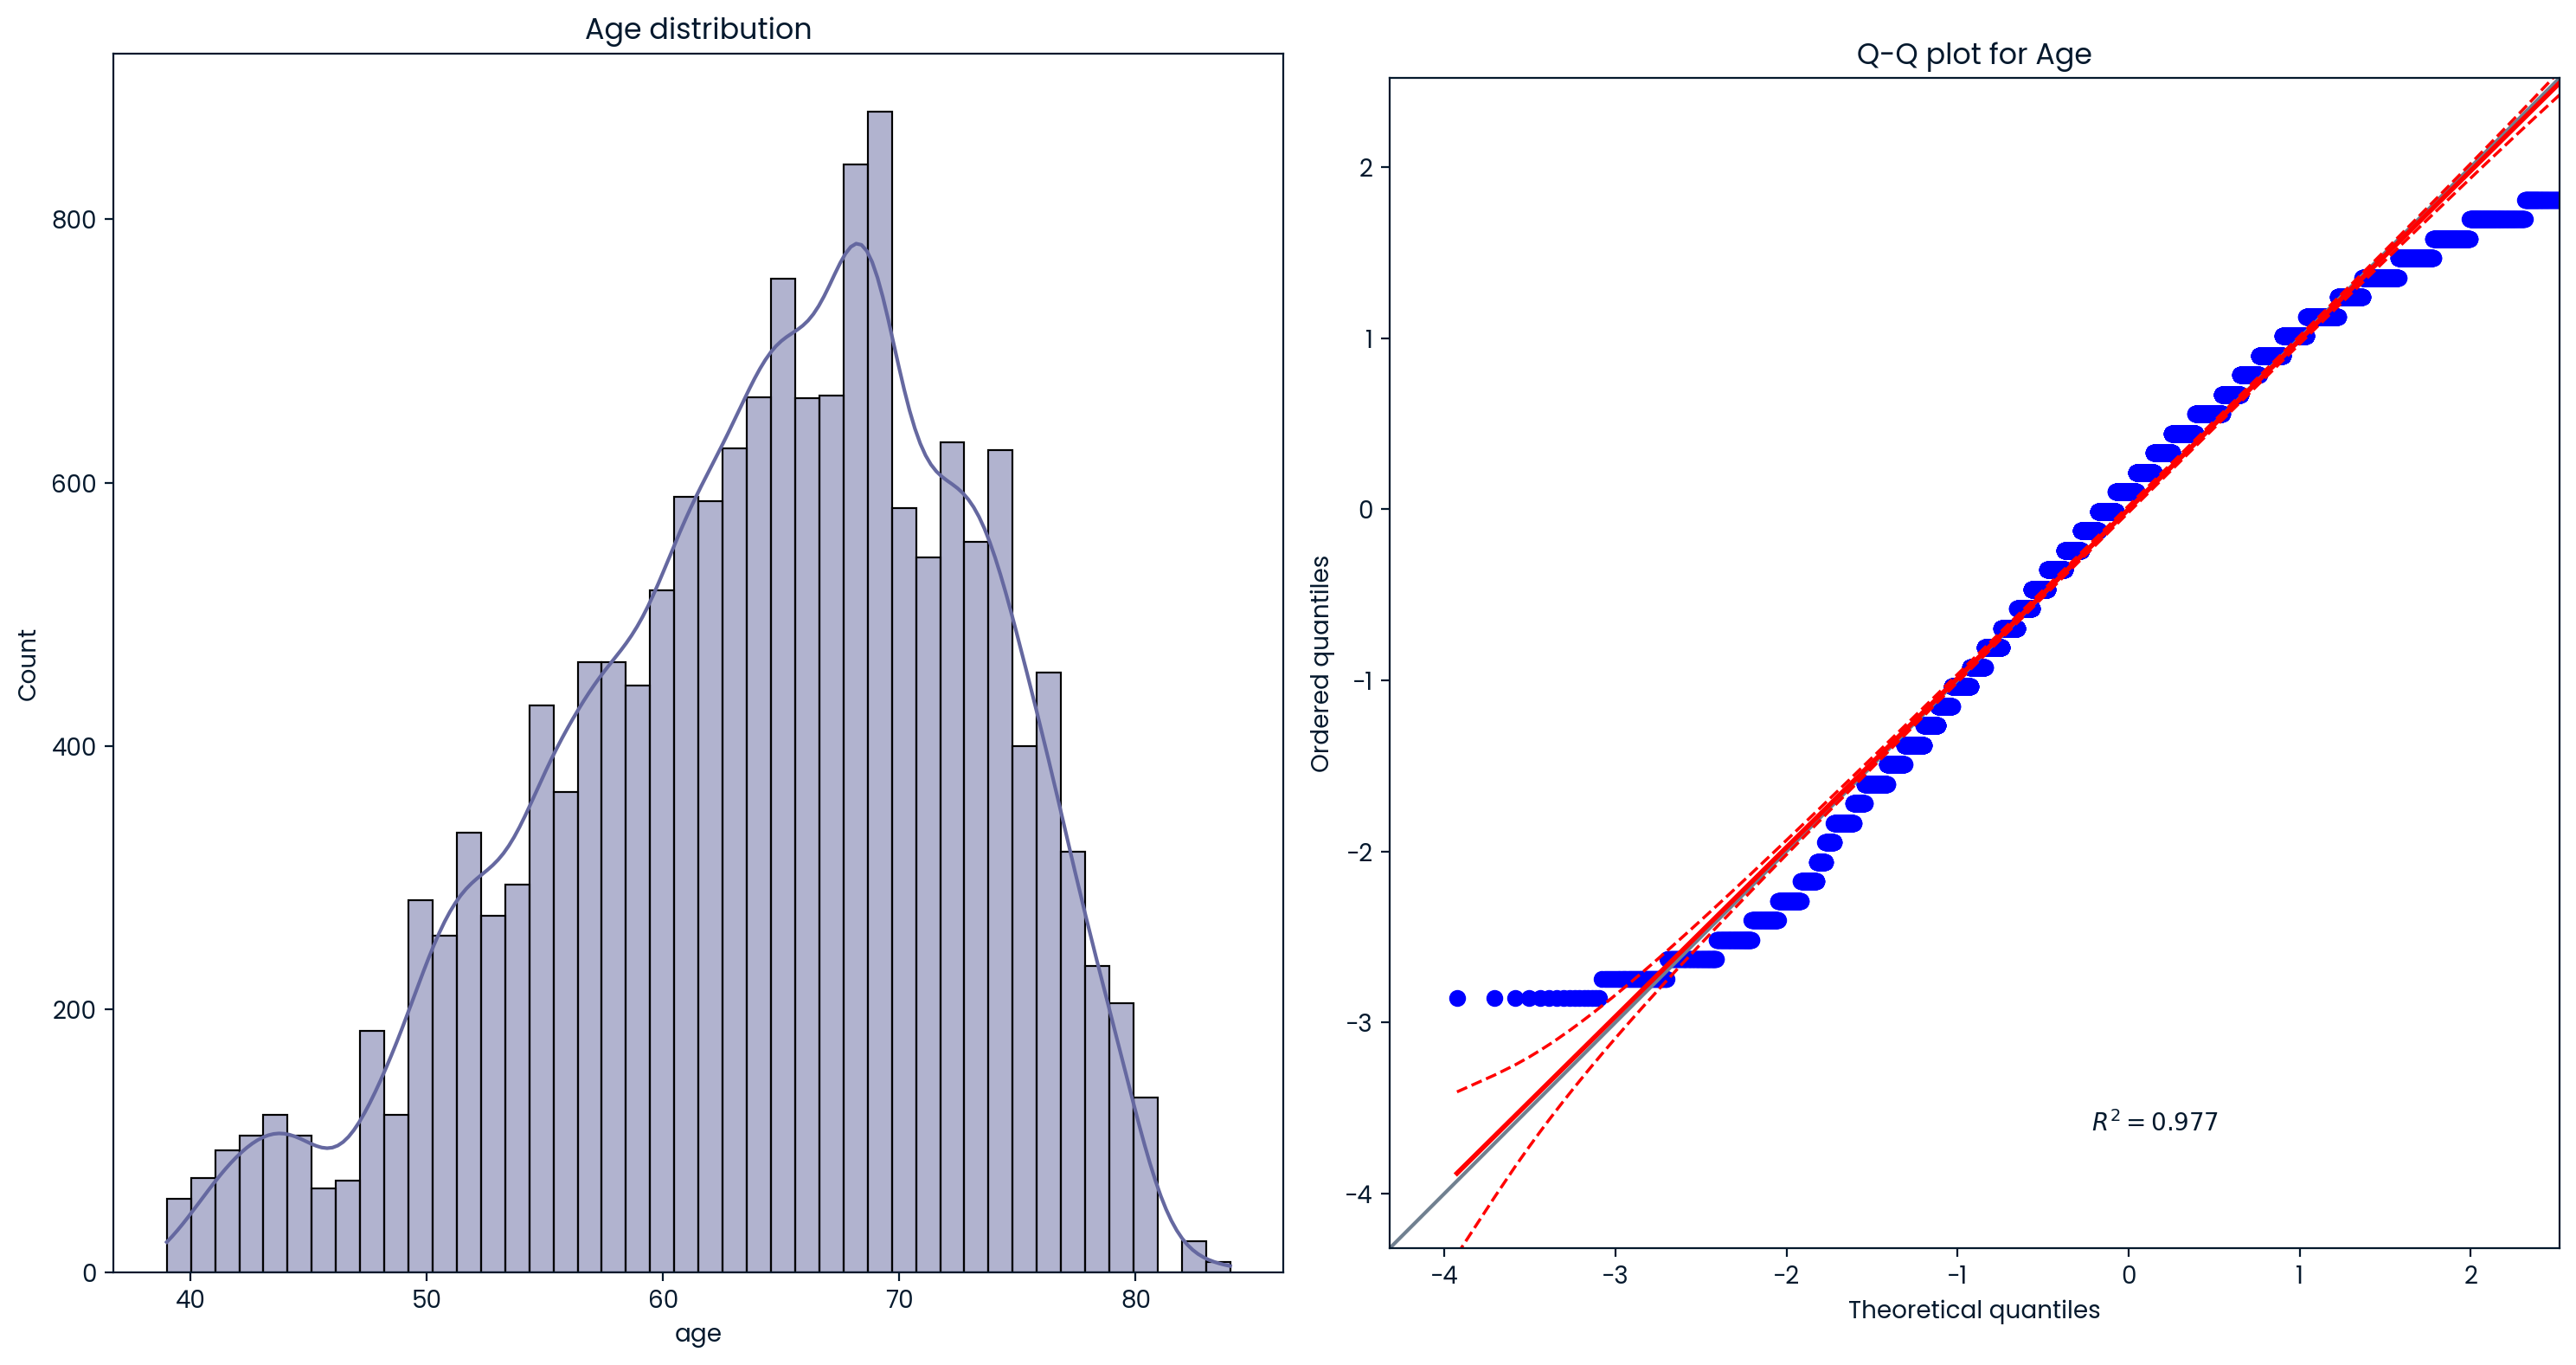

In [ ]:
# visualization: seaborn

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

    # histogram
age_distr = sns.histplot(drug_safety.age, kde=True, ax=ax1)
age_distr.set_title("Age distribution", fontsize=12)

#plt.subplot(1, 2, 2)
    # q-q plot
age_qqplot = pingouin.qqplot(drug_safety.age, ax=ax2)
age_qqplot.set_title("Q-Q plot for Age", fontsize=12)

plt.tight_layout()

>> Notes: 
- from the histogram, we observe that age distribution is slightly skewed to the left
- from the q-q plot, it seems that age mostly follows a normal distribution with slight deviations in the tails
- to clarify the normality of age, we can statistically check for normality 

In [ ]:
# perform normality test for drug safety dataset
pingouin.normality(drug_safety)

,W,pval,normal
age,0.976747,1.121039e-44,False
week,0.863866,0.000000e+00,False
wbc,0.937121,0.000000e+00,False
rbc,0.984640,2.927263e-30,False
num_effects,0.336510,0.000000e+00,False


Note: statistical confirmation that the drug_effect data does not follow a normal distribution, hence why a non-parameteric test is required.

#### 3.3 Is there a significant difference between the ages of the participants in the Drug vs. the Placebo group?
- `Test:` Mann-Whitney U Test
    - H0: there is no difference between the age median of the drug group vs the age median of the 
          placebo group
    - HA: there is a difference between the age median of the drug group vs the age median of the 
          placebo group (two-sided)
- `Output Variable:` age_group_effects_p_value

In [221]:
# proportion of yes (drug) to no (placebo)
age_trx = drug_safety[["age", "trx"]]
age_trx_wide = age_trx.pivot(columns="trx",
                             values ="age")
print(age_trx_wide)

trx    Drug  Placebo
0      62.0      NaN
1      62.0      NaN
2      62.0      NaN
3      62.0      NaN
4      62.0      NaN
...     ...      ...
16098   NaN     78.0
16099   NaN     78.0
16100   NaN     78.0
16101   NaN     78.0
16102   NaN     78.0

[16103 rows x 2 columns]


In [ ]:
# calculate (two-tailed) mann whitney u test because data distribution is not normal 
age_trx_mwu = pingouin.mwu(x = age_trx_wide["Drug"], 
                           y = age_trx_wide["Placebo"],
                           alternative = 'two-sided')
age_trx_mwu

,U-val,alternative,p-val,RBC,CLES
MWU,29149339.5,two-sided,0.256963,-0.01093,0.505465


In [ ]:
# mann whitney u test result
age_group_effects_p_value = age_trx_mwu["p-val"]
print(age_group_effects_p_value)

MWU    0.256963
Name: p-val, dtype: float64


>> Conclusion: As the p-value is greater than 0.05, we cannot reject the null hypothesis. Meaning, that there is no difference between the median age of the treatment group versus the control group.

### 4. Summary

>> **Analysis Goal:**
<br> This analysis examines whether there are significant differences between the treatment and placebo group with regards to the age of the participants, and the proportion of adverse effects.

>> **Adverse Effects And Treatment Group:**
<br> As investigated using a two sample proportions z test, there is no significant difference in the proportion of adverse effects experienced in the different groups. In addition, we observe that the number of adverse effects experienced by participants is independent of their treatment group. Based on these results, one can suggest that the drug treatment does not significantly contribute to the experience of an adverse effect.

>> **Age And Treatment Group:**
<br> Lastly, we also see that for age, there is no significant difference in median age of the participants in the treatment versus the placebo group. Most participants are adults with the median age being 65 years old.